In [1]:
import csv
import pandas as pd
import numpy as np
import sklearn.utils

from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, utils
import torch.nn.functional as F
import torch.nn.init as torch_init

import matplotlib.pyplot as plt


In [2]:
# Get dataframe and simple pared down version of it , note 5500 workds
training_dataframe = sklearn.utils.shuffle(pd.read_csv("train-balanced-sarcasm.csv")).iloc[:100]

# Create vectorizer to convert words to vectors
vectorizer = CountVectorizer()
vectorizer.fit(training_dataframe['comment'].values.astype('U'))

# Create training data and labels with dataframe and vectorizer
y = np.array(training_dataframe["label"].tolist()).T
x = np.matrix(vectorizer.transform(training_dataframe['comment'].values.astype('U')).toarray())


validation_df = sklearn.utils.shuffle(pd.read_csv("train-balanced-sarcasm.csv")).iloc[500000:501000]
y_valid = np.array(validation_df["label"].tolist()).T
x_valid = np.matrix(vectorizer.transform(validation_df['comment'].values.astype('U')).toarray())

In [3]:
# Dimensions of input for our model
input_dim = x.shape[1]

# Dimension of middle layers (we may not use all three)
mid1 = input_dim
mid2 = input_dim // 2
mid3 = input_dim // 4

output_dim = 2

# Simple neural network which takes a vectorized bag of words as input
class BowNN(nn.Module):  # inheriting from nn.Module!

    # TODO: Improve this by passing in parameters instead of using global variables
    def __init__(self):

        super(BowNN, self).__init__()
        
        ## Activation functions used
        self.tanh = nn.Tanh();

        # Funnly connected layers
        self.fc1 = nn.Linear(input_dim, mid1)
        torch_init.xavier_normal_((self.fc1.weight))
        
        self.fc2 = nn.Linear(mid1, mid3)
        torch_init.xavier_normal_((self.fc2.weight))
        
        self.fc3 = nn.Linear(mid3, output_dim) 
        torch_init.xavier_normal_((self.fc3.weight))

    # Standard forward pass code
    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.fc3(out)
        
        return out

In [4]:
# Initialize device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BowNN().to(device)
    
# Use cross entropy loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

In [5]:
# Training code

miniBatches = (list(zip(np.split(y, 50), np.split(x,50))))

for epoch in range(10):
    
    # Get validation accuracy
    v_inputs, v_targets = torch.from_numpy(x_valid).float().to(device), torch.from_numpy(y_valid).long().to(device)
    outputs = model(v_inputs)
    
    predictions = outputs.max(dim = 1)[1]
    begin_accuracy = torch.sum(predictions == v_targets).item() / v_targets.size()[0]
    print("VALID Accuracy at beginning of epoch" )
    print(begin_accuracy)
    
    for batch in miniBatches:

        curInput = batch[1]
        curLabel = batch[0]
    
        inputs, targets = torch.from_numpy(curInput).float().to(device), torch.from_numpy(curLabel).long().to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        
        loss.backward()

        optimizer.step()
        
    outputs = model(v_inputs)
    predictions = outputs.max(dim = 1)[1]
    end_accuracy = torch.sum(predictions == v_targets).item() / v_targets.size()[0]
    print("VALID Accuracy at END of epoch" )
    print(end_accuracy)    
    
    if (end_accuracy < begin_accuracy):
        print("DONE TRAINING")
        break;
        
    print("\n")

VALID Accuracy at beginning of epoch
0.538
VALID Accuracy at END of epoch
0.515
DONE TRAINING


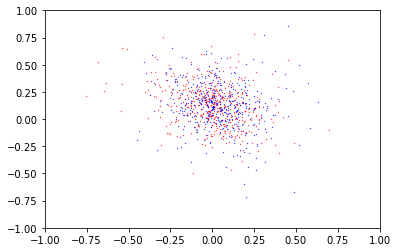

In [7]:
# TODO: turn this into a function, call it between training

# Plot validation points (dimensionality reduction)
v_inputs, v_targets = torch.from_numpy(x_valid).float().to(device), torch.from_numpy(y_valid).long().to(device)

# Get outputs of model
np_outputs = model(v_inputs).detach().numpy()
np_targets = v_targets.numpy()

pos_data = []
neg_data = []

# Allicate data for plotting
for index in range(np_targets.size):
    if (np_targets[index] == 1):
        pos_data.append(np_outputs[index])
    else:
        neg_data.append(np_outputs[index])
        

plt.ylim([-1,1])
plt.xlim([-1,1])
plt.scatter(np.array(pos_data)[:,0], np.array(pos_data)[:,1], c="red", s = .1)
plt.scatter(np.array(neg_data)[:,0], np.array(neg_data)[:,1], c="blue", s = .1)

plt.show()
